<a href="https://colab.research.google.com/github/hongnha17/DeepLearning/blob/main/DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bước 1: Import thư viện**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd


from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, MaxPooling2D,Add, GlobalAveragePooling2D, ZeroPadding2D, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

from tensorflow.keras.models import load_model, Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Đường dẫn đến thư mục chứa dữ liệu ảnh
data_dir = '/content/drive/MyDrive/DA Học Sâu/dataset_test/'

In [ ]:
import os

def get_folder_size(folder_path):
    total = 0
    for path, dirs, files in os.walk(folder_path):
        for f in files:
            fp = os.path.join(path, f)
            total += os.path.getsize(fp)
    return total

data_dir = '/content/drive/MyDrive/DA Học Sâu/dataset_test/'
size_in_bytes = get_folder_size(data_dir)
size_in_MB = size_in_bytes / (1024**2)

print(f"Kích thước của tập dữ liệu: {size_in_MB} MB")


Kích thước của tập dữ liệu: 65.6898021697998 MB


# **Bước 2 : Tiền xử lý dữ liệu**

In [ ]:
import os
from sklearn.model_selection import train_test_split

# Đường dẫn đến thư mục chứa ảnh của mỗi lớp
people_path = "/content/drive/MyDrive/DA Học Sâu/dataset_test/people"
bike_path = "/content/drive/MyDrive/DA Học Sâu/dataset_test/bike"
car_path = "/content/drive/MyDrive/DA Học Sâu/dataset_test/car"
motobike_path = "/content/drive/MyDrive/DA Học Sâu/dataset_test/motorbike"

# Đọc danh sách ảnh từ mỗi thư mục
people_images = [os.path.join(people_path, img) for img in os.listdir(people_path)]
bike_images = [os.path.join(bike_path, img) for img in os.listdir(bike_path)]
car_images = [os.path.join(car_path, img) for img in os.listdir(car_path)]
motobike_images = [os.path.join(motobike_path, img) for img in os.listdir(motobike_path)]

# Chia thành tập train, test và validation cho mỗi lớp
people_train, people_temp = train_test_split(people_images, test_size=0.2, random_state=42)
people_test, people_validation = train_test_split(people_temp, test_size=0.25, random_state=42)

bike_train, bike_temp = train_test_split(bike_images, test_size=0.2, random_state=42)
bike_test, bike_validation = train_test_split(bike_temp, test_size=0.25, random_state=42)

car_train, car_temp = train_test_split(car_images, test_size=0.2, random_state=42)
car_test, car_validation = train_test_split(car_temp, test_size=0.25, random_state=42)

motobike_train, motobike_temp = train_test_split(motobike_images, test_size=0.2, random_state=42)
motobike_test, motobike_validation = train_test_split(motobike_temp, test_size=0.25, random_state=42)

# Tổng hợp tất cả các tập dữ liệu
train_data = people_train + bike_train + car_train + motobike_train
test_data = people_test + bike_test + car_test + motobike_test
validation_data = people_validation + bike_validation + car_validation + motobike_validation

print("Số lượng hình ảnh trong tập train: ", len(train_data))
print("Số lượng hình ảnh trong tập test: ", len(test_data))
print("Số lượng hình ảnh trong tập validation: ", len(validation_data))

Số lượng hình ảnh trong tập train:  840
Số lượng hình ảnh trong tập test:  156
Số lượng hình ảnh trong tập validation:  54


In [ ]:
#Gan nhan du lieu
label=['people','bike','car','motorbike']

In [ ]:
import cv2
import numpy as np

num_classes = 4
def load_and_preprocess_images(images, labels=None, target_size=(224, 224)):
    processed_images = []
    processed_labels = []

    if labels is not None:
        for img_path, label in zip(images, labels):
            img = cv2.imread(img_path)

            #chuyển đổi ảnh xám và resize lại ảnh
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, target_size)
                img = img / 255.0

                processed_images.append(img)
                processed_labels.append(label)
            else:
                print(f"Error loading image: {img_path}")

        return np.array(processed_images), np.array(processed_labels)
    else:
        for img in images:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, target_size)
            img = img / 255.0

            processed_images.append(img)

        return np.array(processed_images)


# Tiền xử lý dữ liệu
X_train, y_train = load_and_preprocess_images(train_data, [0]*len(people_train) +
                                              [1]*len(bike_train) + [2]*len(car_train) + [3]*len(motobike_train))

X_test, y_test = load_and_preprocess_images(test_data, [0]*len(people_test) +
                                              [1]*len(bike_test) + [2]*len(car_test) + [3]*len(motobike_test))

X_validation, y_validation = load_and_preprocess_images(validation_data, [0]*len(people_validation) +
                                              [1]*len(bike_validation) + [2]*len(car_validation) + [3]*len(motobike_validation))

# Chuyển đổi nhãn thành dạng one-hot encoding
y_train_onehot = to_categorical(y_train, num_classes)
y_test_onehot = to_categorical(y_test,num_classes)
y_validation_onehot = to_categorical(y_validation,num_classes)

# Kiểm tra kích thước của các tập dữ liệu
print("Training Data Shape:", X_train.shape)
print("Training Labels Shape:", y_train_onehot.shape)

Training Data Shape: (840, 224, 224, 3)
Training Labels Shape: (840, 4)


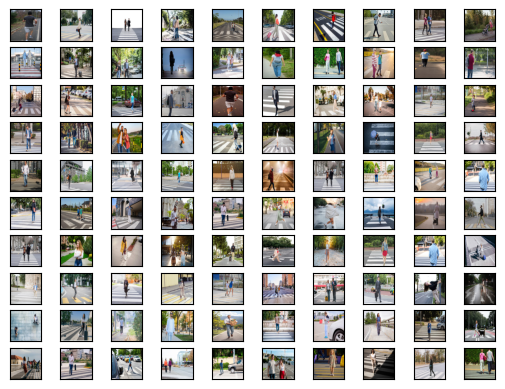

In [ ]:
fig = plt.figure()
for i in range(100):
  ax = fig.add_subplot(10,10,i+1,xticks=[] , yticks=[]) #10 dòng, mỗi dòng 10 ảnh
  ax.imshow(X_train[i])

# **Dự đoán phân loại đối tượng trong ảnh**

# **Mô hình CNN**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Xây dựng mô hình CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # Số lớp đầu ra tương ứng với số lớp của bạn

# Biên dịch mô hình
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình
history = model.fit(X_train, y_train_onehot, epochs=100, validation_data=(X_validation, y_validation_onehot))

In [ ]:
# Hiển thị thông tin về mô hình
model.summary()

In [ ]:
# Biểu đồ độ chính xác trên tập huấn luyện và tập kiểm thử
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Biểu đồ hàm mất mát trên tập huấn luyện và tập kiểm thử
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Đánh giá mô hình trên tập test
test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# **Mô hình MLP**

In [ ]:

# Xây dựng mô hình MLP
mlp_model = Sequential()

# Thêm tầng Flatten để chuyển đổi hình ảnh 2D thành vector 1D
mlp_model.add(Flatten(input_shape=(224, 224, 3)))

# Thêm các tầng ẩn
mlp_model.add(Dense(512, activation='relu'))
mlp_model.add(Dense(256, activation='relu'))

# Tầng đầu ra với 4 nơ-ron (số lượng lớp)
mlp_model.add(Dense(4, activation='softmax'))

# Biên soạn mô hình
mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Hiển thị cấu trúc của mô hình
mlp_model.summary()


In [ ]:
# Sử dụng mô hình
from google.colab import files
from keras.preprocessing import image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

uploaded=files.upload()
for fn in uploaded.keys():
  path='/content/'+fn
  plt.imshow(mpimg.imread(path))

img = image.load_img(path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
y_predict = model.predict(images, batch_size=10)

print(y_predict)
print('Doi tuong thuoc loai:', label[np.argmax(y_predict)])

In [ ]:
# Huấn luyện mô hình
history = mlp_model.fit(
    X_train, y_train_onehot,
    epochs=100,
    batch_size=32,
    validation_data=(X_validation, y_validation_onehot)
)

# Đánh giá mô hình trên tập test
test_loss, test_acc = mlp_model.evaluate(X_test, y_test_onehot)
print(f'Test accuracy: {test_acc}')

# Vẽ biểu đồ đào tạo và đánh giá
import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(history)
# Lưu mô hình train
mlp_model.save("mlp_model.h5")

In [ ]:
from google.colab import files
from keras.preprocessing import image
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load your trained model
model = load_model('/content/mlp_model.h5')

# Define your class labels
label = ['People', 'Bike', 'Car', 'Motorbike']

uploaded = files.upload()

for fn in uploaded.keys():
    path = '/content/' + fn
    plt.imshow(mpimg.imread(path))
    plt.show()

    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])

    # Make predictions using the loaded model
    y_predict = model.predict(images, batch_size=10)

    print(y_predict)
    predicted_class = np.argmax(y_predict)
    print('Predicted Class:', label[predicted_class])


# **Mạng VGG16**


In [ ]:

def build_vgg16_model(input_shape=(224, 224, 3), num_classes=4):
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Xây dựng mô hình VGG16
vgg16_model = build_vgg16_model()

# Biên dịch mô hình
vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Hiển thị thông tin về mô hình
vgg16_model.summary()


In [ ]:
# Huấn luyện mô hình
history = vgg16_model.fit(
    X_train, y_train_onehot,
    epochs=100,  # Số lần lặp lại
    batch_size=32,  # Kích thước batch
    validation_data=(X_validation, y_validation_onehot)
)

# Hiển thị đồ thị biểu đồ về quá trình huấn luyện
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
#kiểm tra độ chính xác của mô hình
test_loss, test_accur = vgg16_model.evaluate(X_test, y_test_onehot)
print(f'Test Accuracy: {test_accur * 100:.2f}%')

# **Mô hình ResNet50**

cài đặt IdentityBlock

In [ ]:
def identity_block(X, filters):
    F1, F2, F3 = filters

    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
    X = BatchNormalization(axis=3)(X)

    # Final step: Add shortcut value to main path
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
import tensorflow as tf
if __name__ == '__main__':
  input_shape =(224,224,3)
  input = tf.keras.layers.Input(shape = input_shape)
  output = identity_block(input, filters=[3,3,3])
  model = Model(inputs=input, outputs=output)
  print(model.summary())


Cài đặt Convolutional Block

In [ ]:
def convolutional_block(X, filters, s=2):
    F1, F2, F3 = filters
    X_shortcut = X

    X = Conv2D(F1, (1, 1), strides=(s, s), padding='valid')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Second layer
    X = Conv2D(F2, (3, 3), strides=(1, 1), padding='same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Third layer
    X = Conv2D(F3, (1, 1), strides=(1, 1), padding='valid')(X)
    X = BatchNormalization(axis=3)(X)

    # Shortcut path
    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), padding='valid')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)

    # Merge
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
input = tf.keras.layers.Input(shape=(224, 224, 3))
output = convolutional_block(input, filters=[3, 3, 3])
model = tf.keras.Model(inputs=input, outputs=output)
print(model.summary())

Cài đặt ResNet50


In [ ]:
from keras.layers import Input, Conv2D, BatchNormalization, Activation, ZeroPadding2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Add, Flatten
from keras.models import Model

def ResNet50(input_shape=(224, 224, 3), classes=4):
    input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, filters=[64, 64, 256], s=1)
    X = identity_block(X, filters=[64, 64, 256])
    X = identity_block(X, filters=[64, 64, 256])

    # Stage 3
    X = convolutional_block(X, filters=[128, 128, 512], s=2)
    X = identity_block(X, filters=[128, 128, 512])
    X = identity_block(X, filters=[128, 128, 512])
    X = identity_block(X, filters=[128, 128, 512])

    # Stage 4
    X = convolutional_block(X, filters=[256, 256, 1024], s=2)
    X = identity_block(X, filters=[256, 256, 1024])
    X = identity_block(X, filters=[256, 256, 1024])
    X = identity_block(X, filters=[256, 256, 1024])
    X = identity_block(X, filters=[256, 256, 1024])
    X = identity_block(X, filters=[256, 256, 1024])

    # Stage 5
    X = convolutional_block(X, filters=[512, 512, 2048], s=2)
    X = identity_block(X, filters=[512, 512, 2048])
    X = identity_block(X, filters=[512, 512, 2048])

    # Global Average Pooling
    X = GlobalAveragePooling2D()(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax')(X)

    return Model(inputs=input, outputs=X)

resnet_model = ResNet50(input_shape=(224,224,3), classes=num_classes)

# Biên dịch mô hình
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Hiển thị thông tin về mô hình
resnet_model.summary()


In [ ]:
# Train the model
history = resnet_model.fit(X_train, y_train_onehot,
                            epochs=100,
                            batch_size=32,
                            validation_data=(X_validation, y_validation_onehot))

# Evaluate the model on the test set
test_loss, test_acc = resnet_model.evaluate(X_test, y_test_onehot)
print(f'Test accuracy: {test_acc}')

# Save the model
resnet_model.save('resnet_model.h5')

# **TRANFER LEARNING WITH FEATURE EXTRACTION**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Khởi tạo generator augmentation với các tham số phù hợp
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

# Tiền xử lý dữ liệu
X_augmented = []
y_augmented = []

# Lặp lại và tạo ra các ảnh mới từ ảnh huấn luyện
for X_batch, y_batch in datagen.flow(X_train, y_train_onehot, batch_size=32, shuffle=True):
    X_augmented.extend(X_batch)
    y_augmented.extend(y_batch)
    if len(X_augmented) >= len(X_train):
        break  # Đảm bảo số lượng ảnh tăng thêm không vượt quá số lượng ảnh huấn luyện ban đầu

X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

# Kiểm tra kích thước của các tập dữ liệu mới
print("Augmented Training Data Shape:", X_augmented.shape)
print("Augmented Training Labels Shape:", y_augmented.shape)


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Tải mô hình VGG16 đã được huấn luyện trước mà không bao gồm lớp đầu ra
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Đóng băng các lớp convolutional
for layer in base_model.layers:
    layer.trainable = False

# Thêm các lớp phân loại tùy chỉnh
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Thêm lớp Dropout với tỷ lệ 0.5
predictions = Dense(num_classes, activation='softmax')(x)

# Kết hợp mô hình cơ sở và các lớp tùy chỉnh thành một mô hình mới
transfer_learning_model = Model(inputs=base_model.input, outputs=predictions)

# Biên dịch mô hình
transfer_learning_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Hiển thị tóm tắt của mô hình
transfer_learning_model.summary()


In [ ]:
# Huấn luyện mô hình
history = transfer_learning_model.fit(X_augmented, y_augmented, epochs=100, validation_data=(X_validation, y_validation_onehot))

In [ ]:
#kiểm tra độ chính xác của mô hình
test_loss, test_ac = transfer_learning_model.evaluate(X_test, y_test_onehot)
print(f'Test Accuracy: {test_ac * 100:.2f}%')

# **TRANSFER LEARNING BẰNG FINE- TUNING**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Tải mô hình VGG16 đã được huấn luyện trước mà không bao gồm lớp đầu ra
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Mở đóng băng một số lớp cuối cùng
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Thêm các lớp phân loại tùy chỉnh
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Kết hợp mô hình cơ sở và các lớp tùy chỉnh thành một mô hình mới
fine_tuned_model = Model(inputs=base_model.input, outputs=predictions)

# Biên dịch mô hình
fine_tuned_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Hiển thị tóm tắt của mô hình
fine_tuned_model.summary()

In [ ]:
# Huấn luyện mô hình
history = fine_tuned_model.fit(X_augmented, y_augmented,
                               epochs=100,
                               validation_data=(X_validation, y_validation_onehot))

In [ ]:
#kiểm tra độ chính xác của mô hình
test_loss, test_a = fine_tuned_model.evaluate(X_test, y_test_onehot)
print(f'Test Accuracy: {test_a * 100:.2f}%')

# **Xác định vị trí**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

def get_data(height, width, parent_directory):
    images = []
    labels = []
    bboxes = []

    # Đường dẫn đến thư mục chứa các thư mục con
    sub_directories = ['people', 'bike', 'car', 'motorbike']

    # Mở file CSV
    rows = pd.read_csv('/content/drive/MyDrive/DA Học Sâu/HS.csv')

    # Lặp qua mỗi thư mục con
    for sub_dir in sub_directories:
        # Đường dẫn đến thư mục con
        sub_directory = os.path.join(parent_directory, sub_dir)

        # Đọc từng dòng trong file CSV
        for index, row in rows.iterrows():
            filename = row['filename']
            xmin = row['xmin']
            ymin = row['ymin']
            xmax = row['xmax']
            ymax = row['ymax']
            label = row['label']
            w = row['width']
            h = row['height']

            # Kiểm tra xem tệp hình ảnh có tồn tại trong thư mục con không
            image_path = os.path.join(sub_directory, filename)
            if not os.path.exists(image_path):
                continue

            # Đọc và xử lý hình ảnh
            image = cv2.imread(image_path)
            if image is not None:
                x1 = float(xmin) / w
                y1 = float(ymin) / h
                x2 = float(xmax) / w
                y2 = float(ymax) / h
                image = cv2.resize(image, (width, height))
                images.append(image)
                labels.append(label)
                bboxes.append((x1, y1, x2, y2))
            else:
                print(f"Error reading image: {image_path}")

    return images, labels, bboxes
def preprocess_input(images, labels, bboxes):
    # Chuyển ảnh về numpy số thực
    images = [image / 255. for image in images]

    # one-hot encoding các labels
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)

    print('Classes: ', lb.classes_)

    # Chia thành 2 tập: train và valid
    images_train, images_valid = train_test_split(images, test_size=0.2, train_size=0.8, random_state=42)
    labels_train, labels_valid = train_test_split(labels, test_size=0.2, train_size=0.8, random_state=42)
    bboxes_train, bboxes_valid = train_test_split(bboxes, test_size=0.2, train_size=0.8, random_state=42)
    return (images_train,labels_train,bboxes_train), (images_valid,labels_valid,bboxes_valid)
if __name__ == "__main__":
  parent_directory = "/content/drive/MyDrive/DA Học Sâu/dataset_test/"
  images, labels, bboxes = get_data(224, 224,parent_directory)
  print("data: ", len(images))

  (images_train, labels_train, bboxes_train), (images_valid, labels_valid, bboxes_valid) = preprocess_input(images, labels, bboxes)
  print("Train: ", len(images_train))
  print("Valid: ", len(images_valid))

In [ ]:
def get_model(height, width, channel):
    input_layer = tf.keras.layers.Input(shape=(height, width, channel))

    # CNN layers
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Flatten()(x)

    # Nhãn lớp
    class_label_output = tf.keras.layers.Dense(4, activation='softmax', name='class_label')(x)

    # Bounding boxes
    bounding_box_output = tf.keras.layers.Dense(4, activation='sigmoid', name='bounding_box')(x)

    # Tạo mô hình với đầu vào và đầu ra
    model = tf.keras.models.Model(inputs=input_layer, outputs=[class_label_output, bounding_box_output])

    # Compile model
    model.compile(optimizer='adam',
                  loss={'class_label': 'categorical_crossentropy', 'bounding_box': 'mean_squared_error'},
                  metrics={'class_label': 'accuracy', 'bounding_box': 'mse'})

    return model
if __name__ == "__main__":
    height, width, channel = (224,224,3)
    model = get_model(height, width, channel)
    print(model.summary())

In [ ]:
if __name__ == "__main__":
    # Kích thước dữ liệu
    height, width, channel, nclasses = (224, 224, 3, 4)

    # Đường dẫn đến thư mục chứa ảnh
    parent_directory = "/content/drive/MyDrive/DA Học Sâu/dataset_test/"

    # Lấy dữ liệu
    images, labels, bboxes = get_data(224, 224, parent_directory)

    # Tiền xử lý dữ liệu
    train_set, val_set = preprocess_input(images, labels, bboxes)
    images_train, labels_train, bboxes_train = train_set
    images_valid, labels_valid, bboxes_valid = val_set

    # Chuyển đổi dữ liệu thành Dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((images_train, {'class_label': labels_train, 'bounding_box': bboxes_train}))
    train_dataset = train_dataset.shuffle(buffer_size=len(images_train)).batch(32)

    valid_dataset = tf.data.Dataset.from_tensor_slices((images_valid, {'class_label': labels_valid, 'bounding_box': bboxes_valid}))
    valid_dataset = valid_dataset.batch(32)

    # Huấn luyện mô hình
    H = model.fit(train_dataset,
              validation_data=valid_dataset,
              epochs=100)

    # Lưu mô hình
    model.save("model.keras")

In [ ]:
def predict(image_path):
    # Load model
    model = tf.keras.models.load_model("model.keras")

    # Load ảnh
    image = cv2.imread(image_path)
    orig_image = image.copy()

    # Resize ảnh và chuẩn hóa
    image = cv2.resize(image, (224, 224))
    image = image.astype("float") / 255.0
    image = np.expand_dims(image, axis=0)

    # Dự đoán nhãn và bounding box
    (label_preds, box_preds) = model.predict(image)
    (x1, y1, x2, y2) = box_preds[0]

    # Chuyển đổi tọa độ bounding box về tọa độ trên ảnh gốc
    (h, w) = orig_image.shape[:2]
    x1 = int(x1 * w)
    y1 = int(y1 * h)
    x2 = int(x2 * w)
    y2 = int(y2 * h)

    # Chuyển đổi nhãn dự đoán thành chuỗi
    predicted_label = str(label_preds[0])

    # Vẽ bounding box và ghi nhãn dự đoán lên ảnh
    cv2.rectangle(orig_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(orig_image, predicted_label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)


    # Hiển thị ảnh
    plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
if __name__ == "__main__":
  # Dự đoán và hiển thị kết quả cho một ảnh cụ thể
  image_path = '/content/drive/MyDrive/DA Học Sâu/dataset_test/motorbike/motorbike02_jpg.rf.d8c5c081557237da6e1f4571d272441e.jpg'
  predict(image_path)
